In [8]:
import pandas as pd
import numpy as np
business_list = pd.read_csv("../datasets/business_list/business_list.csv")


## Ratings
The google places API include rating data and neighborhood data, so computing neighboors by average score is pretty easy.

In [4]:
business_list.head()[['name','rating','neighborhood']] # just to show the relvant parts

,name,rating,neighborhood
0,DBO's,4.8,Sheraden
1,Angkor Restaurant,4.6,Oakwood
2,Blinky's Noble Grill & Bar,4.3,Oakwood
3,Lorenz Cafe,4.1,Elliott
4,NakaEndZone BBQ,4.8,Crafton Heights


<AxesSubplot: title={'center': 'restuants counts'}>

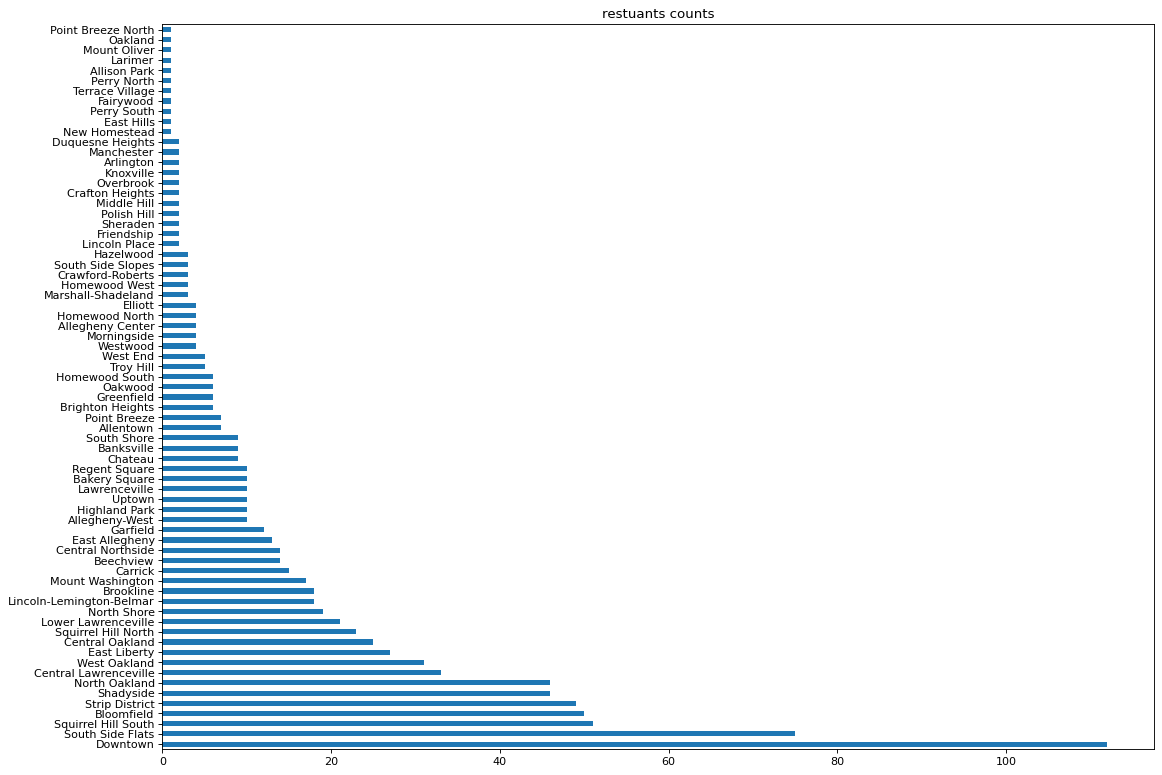

In [71]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

figure(figsize=(16, 12), dpi=80)
ax = business_list['neighborhood'].value_counts().plot.barh()
ax.set_title("restuants counts")
ax # a very quick count

# just counting the resutanunts in each neighboorhood

Text(0.5, 1.0, 'ratings')

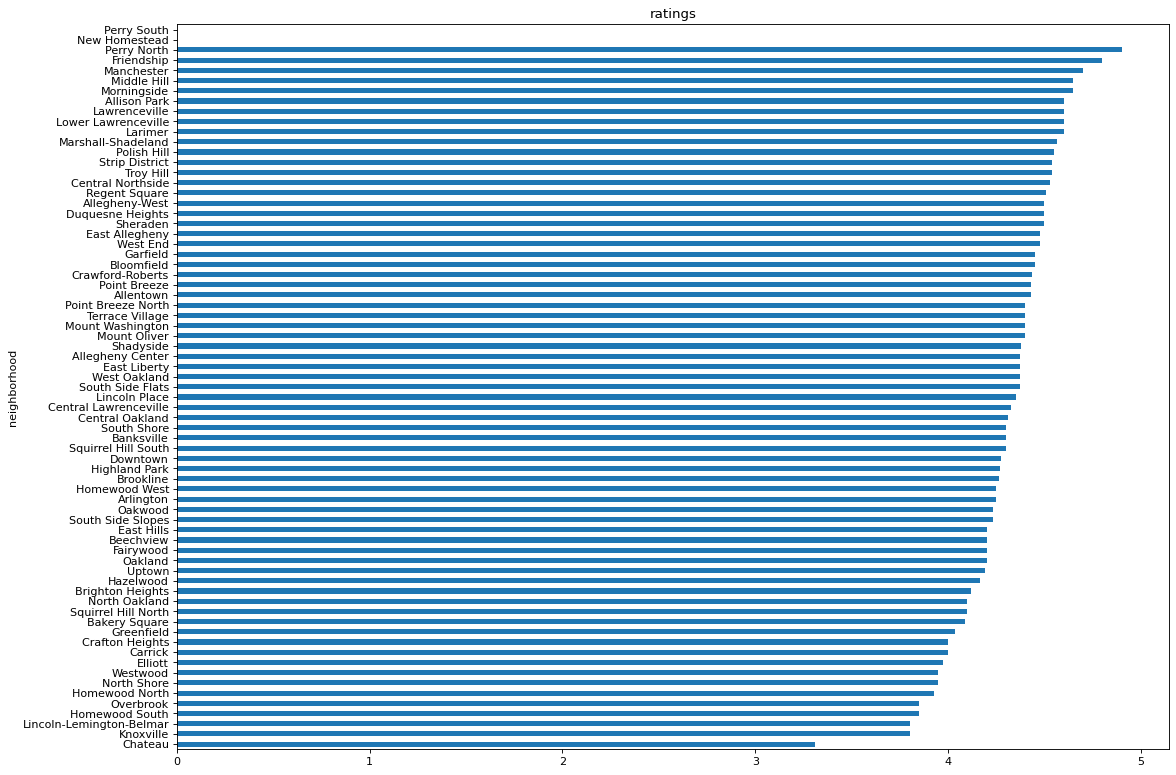

In [72]:
# plot the average ratings
figure(figsize=(16, 12), dpi=80)
ax = business_list.groupby('neighborhood')['rating'].mean().sort_values().plot.barh()
ax.set_title('ratings')

# Health violations

Getting the health violionat of each resutants is a little more involved than ratings.
First we have to import two additonal datasets. One contains the violations themselves, the other will be helpful in mathcing the violations to the correct location.

In [6]:
import zipfile
with zipfile.ZipFile("../datasets/violations/alco-restuarant-violations.zip","r") as zip_ref:
    zip_ref.extractall("../datasets/violations/") # we extract the file
alco_restuarant_violations = pd.read_csv("../datasets/violations/alco-restuarant-violations.csv")
geocoded_factilites = pd.read_csv("../datasets/violations/geo_coded.csv")

In [10]:
alco_restuarant_violations.head()[['id','facility_name','url']]

,id,facility_name,url
0,57066,Rossi's Market,http://appsrv.alleghenycounty.us/reports/rwser...
1,200305220004,Elliotts' Off Broadway Deli,http://appsrv.alleghenycounty.us/reports/rwser...
2,33830,The Pretzel Shop,http://appsrv.alleghenycounty.us/reports/rwser...
3,33830,The Pretzel Shop,http://appsrv.alleghenycounty.us/reports/rwser...
4,48632,Barb's Country Junction Cafe,http://appsrv.alleghenycounty.us/reports/rwser...


In [16]:
geocoded_factilites.head()[['id','facility_name','zip','address']]

,id,facility_name,zip,address
0,10,Joe Winzek Catering Service,15045.0,600 8th Street PA 15045
1,10006,Slavonic Social Club,15104.0,1025 Woodlawn Avenue PA 15104
2,10017,VFW / Post #118,15209.0,605 North Avenue PA 15209
3,10019,Good Time Bar,15209.0,1304 Evergreen Avenue PA 15209
4,10020,Loyal Order Of Moose #68,15209.0,112 Sherman St PA 15209


If we managed to the get the ID of a facility, then we can easily find the matching violations

# Fuzzy search
names of restaurants aren't exactly the same between datasets. this uses a mix of address matching, and fuzzy-matching the names in order to match.

In [9]:

import re
from fuzzywuzzy import fuzz 
# pip install fuzzywuzzy

def normalize_names(name):
  name = name.replace('é','e')
  name = re.sub('[^A-Za-z0-9]+', '', name.lower())
  suffxies = ['bar','restaurant','restaurante','cafe','bbq','diner']
  for s in suffxies:
    if name.endswith(s):
      name = name[:-len(s)]
  prefix = ['the']
  for p in prefix:
    if name.startswith(p):
      name = name[len(p):]
  return name


def best_pick(haystack,needle):
  unnormalized_name = needle
  ans = [(fuzz.ratio(normalize_names(needle),normalize_names(z)),i) for i,z in enumerate(haystack)]
  ans.sort(key=lambda x: x[0])
  if ans[-1][0] < 60:
    return None,None
  return ans[-1]


def address_to_id(R):
  fac_name = R['name']
  street_number = R['street_number']
  postal_code = R['postal_code']
  # print(street_number,postal_code,fac_name)
  query = "num == @street_number and zip==@postal_code"
  row = geocoded_factilites.query(query)

  if row.shape[0] == 1:
    return row.iloc[0]['id']

  if row.shape[0] == 0:
    return None
  
  if row.shape[0] > 1:
    names = list(row['facility_name'])
    _,bp = best_pick(names,fac_name)
    if bp == None:
      return None
    return row.iloc[bp]['id']
    
  return None

ids = business_list.apply(address_to_id,axis=1)
new_list = business_list.assign(id=ids.values).merge(geocoded_factilites,on='id') # we lost about 200 resutants in the process, but that is ok

In [10]:
all_visits = pd.read_csv("/mnt/c/Users/thxs4/Downloads/all_visits.csv")

def t(R):
    n = R['id']
    violations = len(alco_restuarant_violations.query("id==@n and rating == 'V'"))
    try:
        violations_per_visit = violations / len(all_visits.query("id==@n"))
    except ZeroDivisionError:
        return None
    return violations_per_visit

pd.set_option('display.float_format', '{:.4f}'.format)
new_list['violations_avg'] = new_list.apply(t,axis=1)
new_list[['name','place_id','id','violations_avg']]

,name,place_id,id,violations_avg
0,Angkor Restaurant,ChIJb1vGv1_2NIgRTz6RVpyC9Do,200208010001.0000,6.1111
1,Blinky's Noble Grill & Bar,ChIJb1vGv1_2NIgRHMolqSfzEd4,199905270003.0000,2.7857
2,Lorenz Cafe,ChIJX9Zv-Zz2NIgRuL5tXjwo8mU,200801170002.0000,3.4444
3,NakaEndZone BBQ,ChIJPUHlkVH3NIgRMwVmDx22dPM,201812130002.0000,3.3333
4,Burgatory,ChIJFboKMAD0NIgR3_ajWICnKI0,201509040006.0000,2.0370
...,...,...,...,...
713,Misha's Gallery Restaurant,ChIJYX8MOr_tNIgRy3u8brxJ7Vc,200411020007.0000,8.2000
714,D's Six Pax and Dogz,ChIJN3RDUXTuNIgR6nGsrFqr8E8,201804250002.0000,2.3333
715,Chipotle Mexican Grill,ChIJ0VPq8RvtNIgRj5Ga8BZOeHA,201605100004.0000,0.7143
716,Uncle Sam’s Sandwich Bar,ChIJP-ftn8rsNIgRKFmLqVQEOs4,57766.0000,3.2000


In [11]:
new_list[['place_id','id','name','neighborhood','violations_avg','rating']] # all the data we need

,place_id,id,name,neighborhood,violations_avg,rating
0,ChIJb1vGv1_2NIgRTz6RVpyC9Do,200208010001.0000,Angkor Restaurant,Oakwood,6.1111,4.6000
1,ChIJb1vGv1_2NIgRHMolqSfzEd4,199905270003.0000,Blinky's Noble Grill & Bar,Oakwood,2.7857,4.3000
2,ChIJX9Zv-Zz2NIgRuL5tXjwo8mU,200801170002.0000,Lorenz Cafe,Elliott,3.4444,4.1000
3,ChIJPUHlkVH3NIgRMwVmDx22dPM,201812130002.0000,NakaEndZone BBQ,Crafton Heights,3.3333,4.8000
4,ChIJFboKMAD0NIgR3_ajWICnKI0,201509040006.0000,Burgatory,North Shore,2.0370,4.5000
...,...,...,...,...,...,...
713,ChIJYX8MOr_tNIgRy3u8brxJ7Vc,200411020007.0000,Misha's Gallery Restaurant,Homewood North,8.2000,3.0000
714,ChIJN3RDUXTuNIgR6nGsrFqr8E8,201804250002.0000,D's Six Pax and Dogz,Regent Square,2.3333,4.6000
715,ChIJ0VPq8RvtNIgRj5Ga8BZOeHA,201605100004.0000,Chipotle Mexican Grill,Lincoln-Lemington-Belmar,0.7143,3.6000
716,ChIJP-ftn8rsNIgRKFmLqVQEOs4,57766.0000,Uncle Sam’s Sandwich Bar,Lincoln-Lemington-Belmar,3.2000,4.4000


Text(0.5, 1.0, 'Health violations per insepctions')

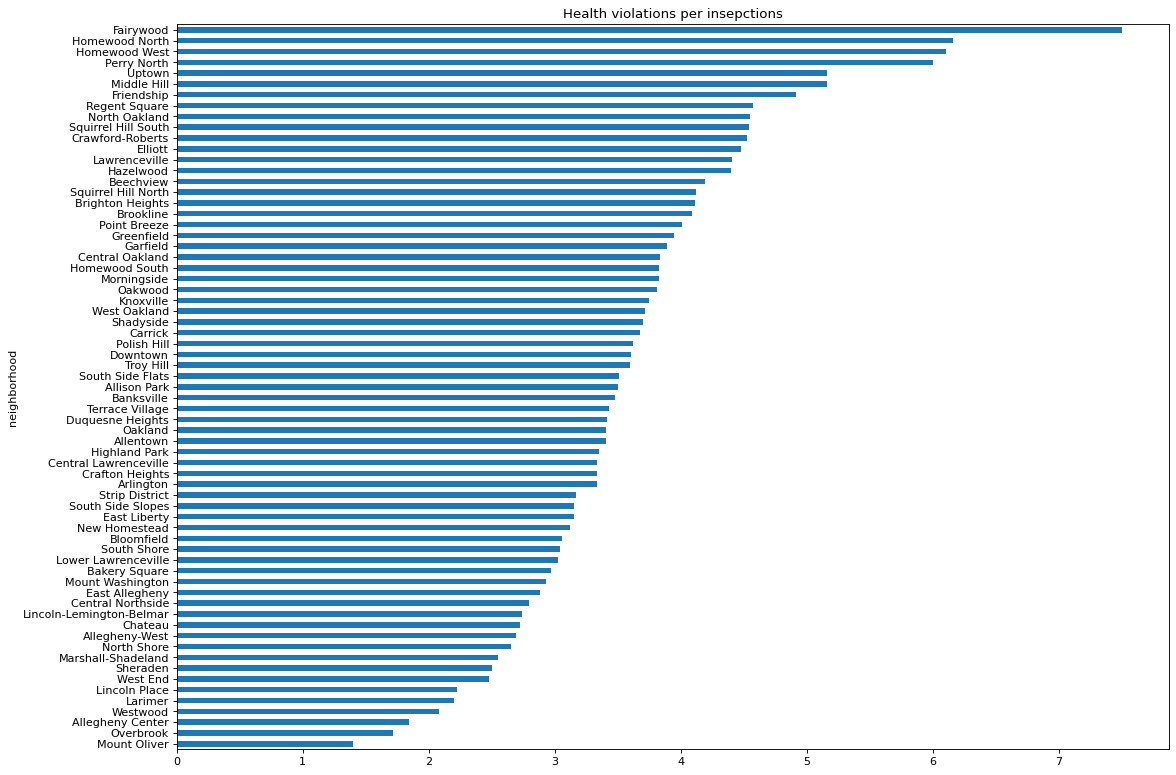

In [68]:
fig = figure(figsize=(16, 12), dpi=80)
ax = new_list.groupby('neighborhood')['violations_avg'].mean().sort_values().plot.barh()
ax.set_title("Health violations per insepctions")